In [147]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
%matplotlib inline

Data Dictionary
Variable	Definition	Key
survival	Survival	0 = No, 1 = Yes
pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
sex	Sex	
Age	Age in years	
sibsp	# of siblings / spouses aboard the Titanic	
parch	# of parents / children aboard the Titanic	
ticket	Ticket number	
fare	Passenger fare	
cabin	Cabin number	
embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton
Variable Notes
pclass: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

# Step 0: Import data

In [2]:
# Import training data with pandas in a dataframe
path_training = r"data/titanic_train.csv"
path_testing = r"data/titanic_test.csv"
path_answers = r"data/submission.csv"

# Print an example of the training data
df_training = pd.read_csv(path_training)
df_training = pd.read_csv(path_testing)

# Step 1: exploratory data analysis

In [3]:
df_training.describe()

passenger_id     pclass         age       sibsp       parch  \
count    850.000000  850.00000  676.000000  850.000000  850.000000   
mean     662.816471    2.32000   29.519847    0.522353    0.382353   
std      380.751936    0.83853   14.562243    1.112132    0.879511   
min        1.000000    1.00000    0.166700    0.000000    0.000000   
25%      332.250000    2.00000   20.000000    0.000000    0.000000   
50%      676.500000    3.00000   28.000000    0.000000    0.000000   
75%      992.250000    3.00000   37.000000    1.000000    0.000000   
max     1307.000000    3.00000   80.000000    8.000000    9.000000   

             fare        body    survived  
count  849.000000   73.000000  850.000000  
mean    34.012701  165.821918    0.368235  
std     53.705779   99.068487    0.482610  
min      0.000000    4.000000    0.000000  
25%      7.895800   75.000000    0.000000  
50%     14.108300  166.000000    0.000000  
75%     31.000000  260.000000    1.000000  
max    512.329200  328.000000    1.000000

Here we see that we have sample of 850 people in our training set which will be split further down the line in training and validation set. 
Let's start by evaluating how many people out of the 850 survived.

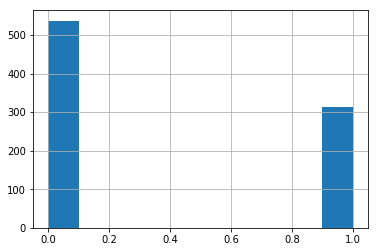

In [4]:
df_training["survived"].hist()

We see that around 530 people died and 310 survived. Now let's use the correlation matix to figure out what feature is the most correlated to the chance of survival.

In [6]:
df_training.corr()

passenger_id    pclass       age     sibsp     parch      fare  \
passenger_id      1.000000  0.896525 -0.340788  0.098996 -0.000191 -0.480013   
pclass            0.896525  1.000000 -0.406071  0.074418 -0.006388 -0.560884   
age              -0.340788 -0.406071  1.000000 -0.251310 -0.159216  0.194609   
sibsp             0.098996  0.074418 -0.251310  1.000000  0.389236  0.141797   
parch            -0.000191 -0.006388 -0.159216  0.389236  1.000000  0.246414   
fare             -0.480013 -0.560884  0.194609  0.141797  0.246414  1.000000   
body             -0.027040 -0.089349  0.168140 -0.121234  0.131441 -0.084357   
survived         -0.305726 -0.329360 -0.042683 -0.044980  0.059172  0.251249   

                  body  survived  
passenger_id -0.027040 -0.305726  
pclass       -0.089349 -0.329360  
age           0.168140 -0.042683  
sibsp        -0.121234 -0.044980  
parch         0.131441  0.059172  
fare         -0.084357  0.251249  
body          1.000000       NaN  
survived           NaN  1.000000

Seems like the fare is loosely correlated to the chance of survival. So the more you pay, for your fare, the more you have a chance of survival. Probably that the cabin in higher class would be located closer to the lifeboats. The poorer people would be in the lower deck which would mean lower chance of survival if the boat would have to become full of water. This assumption would have to be validated. (info about the lifeboats: https://www.historyonthenet.com/the-titanic-lifeboats)

Now let's try to see if the age or the sex is correlated to a higher chance of survival. To do this, we need to find the ones who survived.

In [14]:
has_survived = df_training["survived"]==1
df_survivors = df_training[has_survived]
df_survivors.describe()

passenger_id      pclass         age       sibsp       parch  \
count    313.000000  313.000000  266.000000  313.000000  313.000000   
mean     510.434505    1.958466   28.748747    0.456869    0.450479   
std      372.002571    0.870566   15.451123    0.659418    0.737030   
min        1.000000    1.000000    0.166700    0.000000    0.000000   
25%      183.000000    1.000000   19.000000    0.000000    0.000000   
50%      446.000000    2.000000   28.000000    0.000000    0.000000   
75%      851.000000    3.000000   36.000000    1.000000    1.000000   
max     1300.000000    3.000000   80.000000    4.000000    4.000000   

             fare  body  survived  
count  313.000000   0.0     313.0  
mean    51.660025   NaN       1.0  
std     72.972568   NaN       0.0  
min      0.000000   NaN       1.0  
25%     12.350000   NaN       1.0  
50%     26.000000   NaN       1.0  
75%     59.400000   NaN       1.0  
max    512.329200   NaN       1.0

Let's repeat the process but for the unlucky ones

In [15]:
has_died = df_training["survived"]==0
df_casualties = df_training[has_died]
df_casualties.describe()

passenger_id      pclass         age       sibsp       parch  \
count    537.000000  537.000000  410.000000  537.000000  537.000000   
mean     751.635009    2.530726   30.020122    0.560521    0.342644   
std      357.229865    0.742805   13.951860    1.304615    0.951191   
min        2.000000    1.000000    0.750000    0.000000    0.000000   
25%      466.000000    2.000000   21.000000    0.000000    0.000000   
50%      776.000000    3.000000   28.000000    0.000000    0.000000   
75%     1070.000000    3.000000   38.000000    1.000000    0.000000   
max     1307.000000    3.000000   74.000000    8.000000    9.000000   

             fare        body  survived  
count  536.000000   73.000000     537.0  
mean    23.707454  165.821918       0.0  
std     34.318401   99.068487       0.0  
min      0.000000    4.000000       0.0  
25%      7.854200   75.000000       0.0  
50%     10.500000  166.000000       0.0  
75%     26.000000  260.000000       0.0  
max    263.000000  328.000000       0.0

Ok, seems like people who were a little bit younger survived and people who payed a higher fare did survive but it does not seem to be very . The sex in not shown in the correlation matrices since they are categorical feature. Let's one hot encode them to see the effect of sex on survival rate. 

In [22]:
pd.get_dummies(df_survivors["sex"]).describe()

female        male
count  313.000000  313.000000
mean     0.670927    0.329073
std      0.470629    0.470629
min      0.000000    0.000000
25%      0.000000    0.000000
50%      1.000000    0.000000
75%      1.000000    1.000000
max      1.000000    1.000000

In [23]:
pd.get_dummies(df_casualties["sex"]).describe()

female        male
count  537.000000  537.000000
mean     0.165736    0.834264
std      0.372190    0.372190
min      0.000000    0.000000
25%      0.000000    1.000000
50%      0.000000    1.000000
75%      0.000000    1.000000
max      1.000000    1.000000

For the survivors, looks like 67.09 % of the survivors were female and for the casualties, 16.57% were female. So we can affirm that sex definitvely been a prime factor for survival. Let's see what the age distribution tells us.

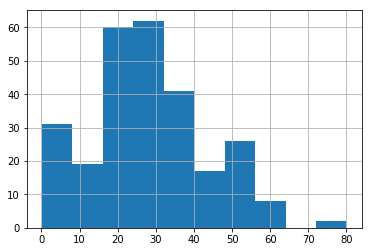

In [36]:
df_survivors["age"].hist()

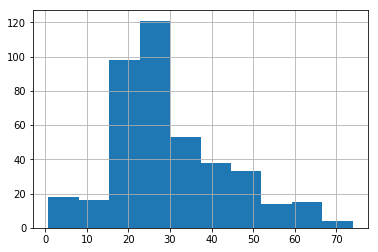

In [37]:
df_casualties["age"].hist()

By looking a the difference between the buckets in the histograms, kids between 0 to 10 seemed to have been alright. Probably that they were with their parents (mother most probably)

# Step 2: create heuristic for the baseline
Let's start by using a simple algorithm to set a baseline. First we need to prepare the data. We will you the following functions to help with the transformations

In [153]:
def split_data(df, y):
    "returns a tuple: X_train, X_test, y_train, y_test"
    return train_test_split(df, y, test_size=0.2)

def prepare_dataframe(df):
    # the name has a high probability of being irrelevant so we will drop the feature. 
    df_temp = df.drop(['name'], axis=1)
    X_temp = df_temp.fillna(df_temp.mean())
    X_train_one_hot_encoded = pd.get_dummies(X_temp)
    return X_train_one_hot_encoded.as_matrix()

def train_and_evaluate(clf, data):
    # data is expected to be a tuple (X_train, X_test, y_train, y_test)
    X_train = data[0]
    X_test = data[1]
    y_train = data[2]
    y_test = data[3]
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    return accuracy_score(y_test, predictions)

def save_files_to_pickle(data):
    # data is expected to be a tuple (X_train, X_test, y_train, y_test)
    pickle.dump(data[0], open("X_train.p", "wb"))
    pickle.dump(data[1], open("X_test.p", "wb"))
    pickle.dump(data[2], open("y_train.p", "wb"))
    pickle.dump(data[3], open("y_test.p", "wb"))

def load_saved_data():
    X_train = pickle.load(open("X_train.p", "rb"))
    X_test = pickle.load(open("X_test.p", "rb"))
    y_train = pickle.load(open("y_train.p", "rb"))
    y_test = pickle.load(open("y_test.p", "rb"))
    return (X_train, X_test, y_train, y_test)
    

# Step 3: prepare data, create simple model, fit the data and evaluate performance

In [165]:
# We will shuffle and save the splitted data to be able to measure apples with apples. This avoids having different results when re running the calculations
#X_train, X_test, y_train, y_test = split_data(prepare_dataframe(df_training.drop(["survived"], axis=1)), df_training.survived)
save_files_to_pickle((X_train, X_test, y_train, y_test))

/home/guillaume/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [166]:
X_train, X_test, y_train, y_test = load_saved_data()
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
print(train_and_evaluate(clf, (X_train, X_test, y_train, y_test)))

0.6705882352941176


# Step 4: evaluate simple model vs baseline
The models have variable performance but the fraction of correct predictions is between 0.66 and 0.75. This is using the default values of KNeighbors classifier.
Let's try other of the shelf algorithms

In [173]:
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto')

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
kernel = DotProduct() + WhiteKernel()
kernel = 1.0 * RBF(1.0)
clf_gpc = GaussianProcessClassifier(kernel=kernel,random_state=0)

from sklearn.tree import DecisionTreeClassifier
clf_dtc = DecisionTreeClassifier(random_state=0)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
clf_rfc = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

from sklearn.naive_bayes import GaussianNB
clf_nbc = GaussianNB()

print("knn:", train_and_evaluate(clf, (X_train, X_test, y_train, y_test)))
print("svc:", train_and_evaluate(clf_svc, (X_train, X_test, y_train, y_test)))
print("gpc:", train_and_evaluate(clf_gpc, (X_train, X_test, y_train, y_test)))
print("dtc:", train_and_evaluate(clf_dtc, (X_train, X_test, y_train, y_test)))
print("rfc:", train_and_evaluate(clf_rfc, (X_train, X_test, y_train, y_test)))
print("nbc:", train_and_evaluate(clf_nbc, (X_train, X_test, y_train, y_test)))

knn: 0.6705882352941176
svc: 0.7411764705882353
gpc: 0.7470588235294118
dtc: 0.9176470588235294
rfc: 0.9176470588235294
nbc: 0.5235294117647059


SVC and gpc are giving about the same results. Knn and nbc is not performing very well and the decision tree classifiers seems to be overfitting. I would not use the decision trees on the test set so svc and gpc seems to be the best bets but further hyper parameter tuning could improve performance. Further actions would be feature engineering (bucketizing age for example) and repeat until satisfaction.
